# <center> <font style="color:rgb(100,109,254)"> Image Classification with Dnn Module</font> </center>

We have trained Image Classifiers using Traditional AI, then we went on to train Image Classifiers with Machine Learning by using SVM's and HOGs, Now we'll use deep learning. But we're not going to train a classifier but we're going to use a pre-trained one.


## <font style="color:rgb(134,19,348)"> What is ImageNet:   </font>

ImageNet project is a large visual database designed for use in visual object recognition research. More than 14 million images which contains 20,000 classes (synsets). They are also about 1 million images with bounding box annotations, these can used to train Object detectors. Note: ImageNet only provides urls of these images, they needed to be downloaded first.

## <font style="color:rgb(134,19,348)"> What is ImageNet Large Scale Visual Recognition Challenge (ILSVRC):   </font>


ILSVRC is an annual competition organized by the ImageNet team since 2010, Research teams from all over the world come and evaluate their algorithms on various visual recognition tasks. Among these there is a classification task on which you train on 1.2 million consisting of 1000 classes (a subset of ImageNet) and then check out their performance.


So through out the years there have been several algorithms which have performed really well on these tasks. In this notebook we'll be using one such algorithm called GoogleNet. It was also this competition that gave mass popularity to Deep Learning as in 2012 Alex Krizhevsky with Geoffrey Hinton shattered previous records with their AlexNet (a deep learning based model).


## <font style="color:rgb(134,19,348)"> Opencv DNN Module  </font>

Opencv package includes multiple modules, DNN (Deep Neural networks) module is also one of the module among them, it has been present since OpenCV version *3.3*. As you've probably guessed already DNN module allows you to use Deep learning based models in OpenCV. This module was introduced after opencv 3.1 and now in the latest version of opencv 4.0+ the DNN module has improved a lot.

Unfortunately You can't train Neural networks with this module, for that you can use some popular frameworks like Tensorflow, Pytorch etc. But what you can do is import trained networks in your DNN module and use them directly in OpenCV. This means you can perform inference  (a forward pass on a test image), this is like taking a new image, throwing a trained network at it and getting predictions/results from it.

So in this notebook we'll be loading and using a deep learning based classifier called Google Net, which has been trained using the Caffe framework on a subset ILSVRC. In future notebooks we'll also take a look at other networks which could do other tasks like Detection, Segmentation etc. 

**[This page](https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV) on DNN covers a lot about it.**


## <font style="color:rgb(134,19,348)"> DNN Pipeline </font>

Generally there are 4 steps when doing deep learning with DNN module. 

1. Read the image and the target classes.
2. Initialize the DNN module with an architecture and model parameters.
3. Perform the forward pass on the image with the module
4. Post process the results.

## <font style="color:rgb(134,19,348)">  Frameworks Supported with DNN: </font>

-  **`Caffe`** 

-  **`Tensorflow`**

-  **`Pytorch`**

-  **`Darknet`**
 
-  **`ONNX Format Models`**

<i>So you can train your model in any of the above frameworks then take that trained model and directly use it in OpenCV <i>
     

In [41]:
# Importing Required libraries
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk 
import os
import sys

## <font style="color:rgb(134,19,348)"> Loading Class Labels </font>

We'll start of by loading class names, these are classes on which you classify, for e.g for ASL classification you had 29 classes (Alphabets + other classes). Here we are going to classify among 1000 classes defined in ImageNet.



All these classes are in the text file named `synset_words.txt`. In this text file, each class is in on a new line with its unique id, Also each class has multiple labels for e.g look at the first 3 lines in the text file:

- 'n01440764 tench, Tinca tinca' 
- 'n01443537 goldfish, Carassius auratus'
- 'n01484850 great white shark, white shark

So for each line we have the Class ID, then there are multiple class names, they all are valid names for that class and we'll just use the first one. So in order to do that we'll have to extract the second word from each line and create a new list, this will be our labels list.

In [42]:
# Split all the classes by a new line and store it in variable called rows.
rows = open('Media/M4/Model/synset_words.txt').read().strip().split("\n")

# Check the number of classes.
print("Number of Classes "+str(len(rows)))

# Showing the first 5 rows
print(rows[0:5])

Number of Classes 1000
['n01440764 tench, Tinca tinca', 'n01443537 goldfish, Carassius auratus', 'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'n01491361 tiger shark, Galeocerdo cuvieri', 'n01494475 hammerhead, hammerhead shark']


**Extract the Label** <br>
Here we will extract the labels (2nd element from each line) and create a labels list.

In [43]:
# Splitting by comma after first space is found, grabbing the first element and storing it in a new list.
CLASSES = [r[r.find(" ") + 1:].split(",")[0] for r in rows]

# Print the first 50 processed class labels 
print(CLASSES[0:50])

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile']


##  <font style="color:rgb(134,19,348)"> Read An Image </font>
Read the image on which we'll attempt classification.

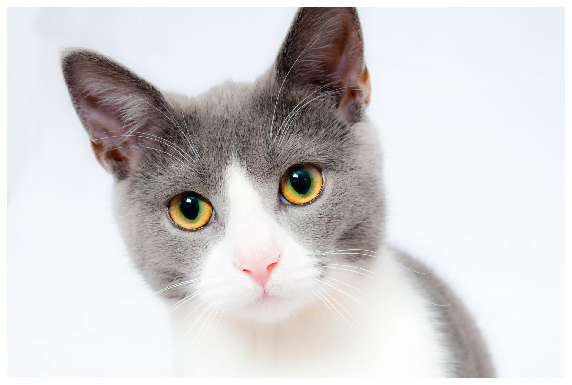

In [44]:
# Load the input image
image = cv2.imread('Media/M4/cat.jpeg')

# Display the image
plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1]);plt.axis("off");

## <font style="color:rgb(134,19,348)">  Initializing the DNN Module </font>

Now before we can use the DNN Module we must initialize it using one of the following functions.

- `Caffe Modles:`      **cv2.dnn.readNetFromCaffe**                                                            
- `Tensorflow Models:` **cv2.dnn.readNetFromTensorFlow** 
- ` Pytorch Models:`   **cv2.dnn.readNetFromTorch**

As you can see the function you use depends upon Original Architecture the model was trained on.

Since we'll be using a Caffe model so our function will be:

[```retval = cv2.dnn.readNetFromCaffe( prototxt[, caffeModel] )```](https://docs.opencv.org/4.2.0/d6/d0f/group__dnn.html#ga29d0ea5e52b1d1a6c2681e3f7d68473a)

**Params:**

- **`prototxt:`**	Path to the .prototxt file, this is the text description of the architecture of the model. 
- **`caffeModel:`**	path to the .caffemodel file, this is your actual trained neural network model, it contains all the weights/parameters of the model. This is usually several MBs in size.

**Note:** If you load the model and proto file via *readNetFromTensorFlow* then the order of architecture and model inputs are reversed.

Here's the Architecture of GoogleNet.
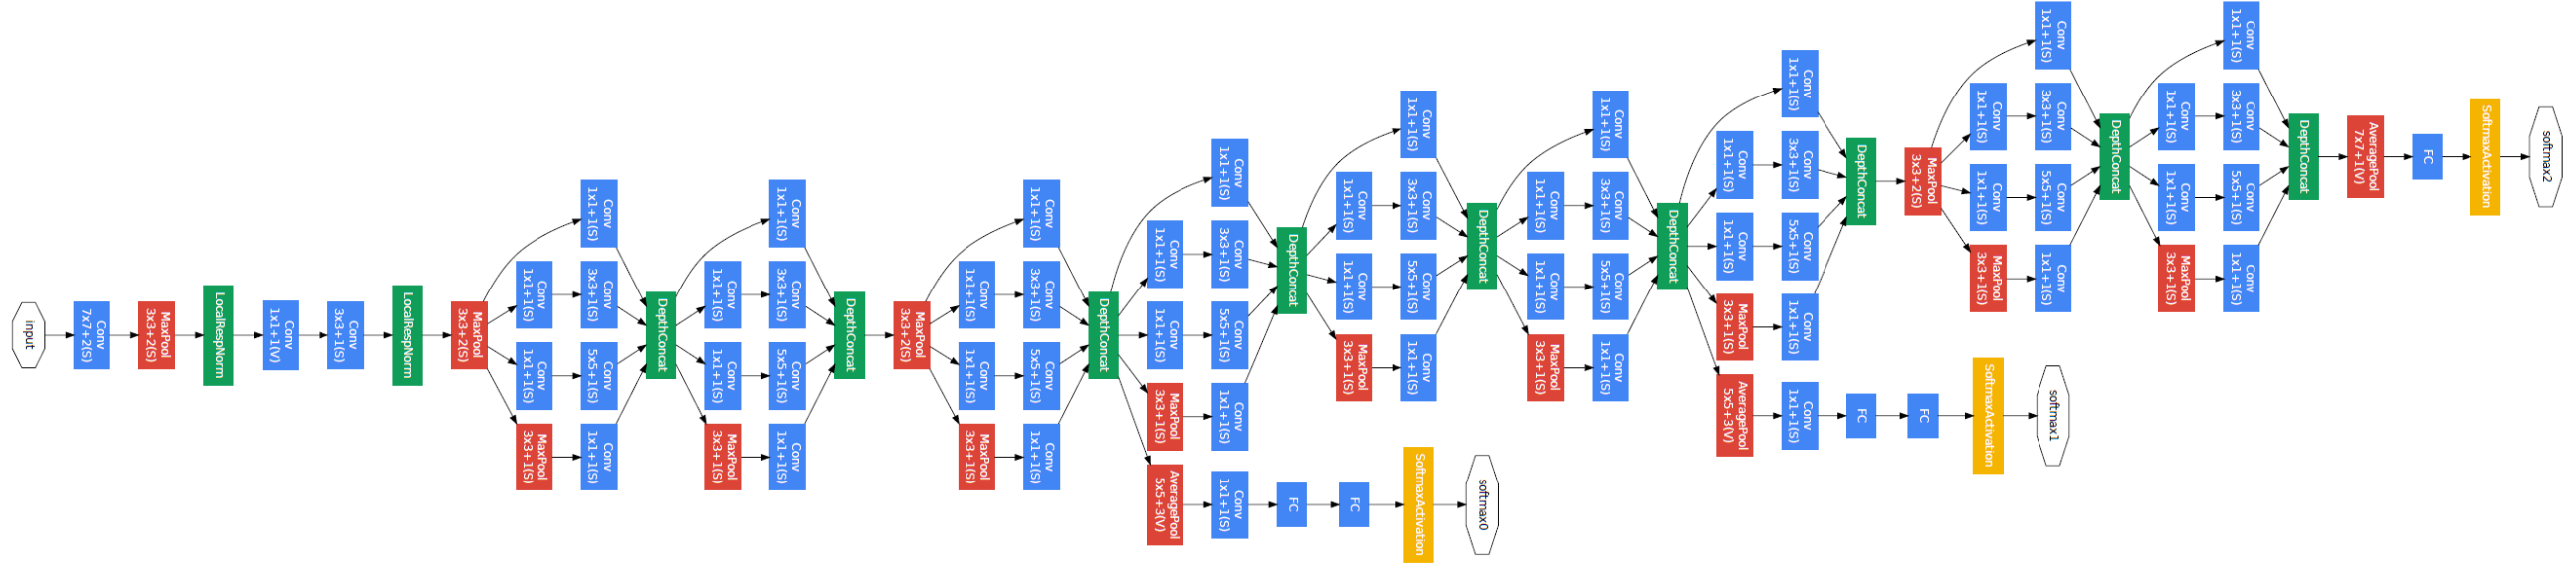

In [45]:
# Load the Model Weights.
weights = 'Media/M4/Model/bvlc_googlenet.caffemodel'

# Load the googleNet Architecture.
architecture ='Media/M4/Model/bvlc_googlenet.prototxt' 

# Initialize the network.
net = cv2.dnn.readNetFromCaffe(architecture, weights)

In [46]:
# Here we are reading pre-trained caffe model with its architecture using opencv dnn module which accepts only 2 parameters 
net = cv2.dnn.readNetFromCaffe(architecture, weights)

## <font style="color:rgb(134,19,348)"> Pre-processing the image</font>

Now before you pass an image in the network you need to preprocess it, this means resizing the image to the size it was trained on, for many networks this is 224x224, in pre-processing step you also do other things like Normalize the image (make the range of intensity values between 0-1) and mean subtraction etc. These are all the steps the authors did on the images that were used during model training.

Fortunately In OpenCV you have a function called **cv2.dnn.blobFromImage()** which most of the times takes care of all the pre-processing for you.

 [```blob = cv2.dnn.blobFromImage(image[, scalefactor[, size[, mean[, swapRB[, crop]]]]])```]( https://docs.opencv.org/4.2.0/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7)

**Params:**

- **`Image`**  Input image.
- **`Scalefactor`**  Used to normalize the image. This value is multiplied by the image, value of 1 means no scaling is done.
- **`Size`**  The size to which the image will be resized to, this depends upon the each model. 
- **`Mean`** These are mean R,G,B Channel values from the whole dataset and these are subtracted from the image's R,G,B respectively, this gives illumination invariance to the model.
- **`swapRB`** Boolean flag (false by default) this indicates weather swap first and last channels in 3-channel image is necessary.
- **`crop`** flag which indicates whether image will be cropped after resize or not. If crop is true, input image is resized so one side after resize is equal to corresponding dimension in size and another one is equal or larger. Then, crop from the center is performed. If crop is false, direct resize without cropping and preserving aspect ratio is performed.

So After this function we get a 4d blob, this is what we'll pass to the network.

In [47]:
blob = cv2.dnn.blobFromImage(image, 1, (224, 224), (104, 117, 123))

 **Note:** There is also [**blobFromImages()**](https://docs.opencv.org/4.2.0/d6/d0f/group__dnn.html#ga0b7b7c3c530b747ef738178835e1e70f) which does the same thing but with multiple images.

## <font style="color:rgb(134,19,348)"> Input the Blob Image to the Network  </font>
Here you're setting up the blob image as the input to the network.

In [48]:
# Passing the blob as input through the network 
net.setInput(blob)

##  <font style="color:rgb(134,19,348)"> Forward Pass </font>
Here the actual computation will take place, Most of the time in your whole pipeline will be taken here. Here your image will go through the all the model parameters and at the end you will get the output of the classifier.

In [50]:
%%time
Output = net.forward()

Wall time: 55 ms


**The Output returned are the probabilities of our 1000 classes, from here we can either get the index of the highest probability class using np.argmax and then use that to index in the CLASS list to get the class name**

In [51]:
# Length of the number of predictions
print("Total Number of Predictions are: {}".format(len(Output[0])))

Total Number of Predictions are: 1000


In [52]:
# These are first fifty Probabilities
Output[0][:50]

array([5.19552941e-06, 2.32161674e-05, 2.71767185e-05, 5.74257501e-06,
       2.35930602e-05, 1.44587266e-05, 8.47088540e-06, 8.44642898e-07,
       1.30970975e-05, 3.80418464e-06, 2.72072248e-06, 7.06937442e-07,
       3.02364606e-06, 3.18119455e-05, 2.26717361e-06, 3.23814993e-06,
       2.22097151e-05, 2.75516413e-05, 1.82794361e-06, 2.39301448e-06,
       1.36530991e-06, 7.58296164e-06, 1.94102040e-06, 2.00014438e-06,
       2.97106471e-05, 2.65698134e-07, 5.38737254e-07, 1.35535822e-06,
       1.79023527e-06, 8.59610850e-07, 5.34597540e-08, 6.14507201e-07,
       6.25978032e-07, 1.10179235e-06, 5.33702496e-06, 2.34432468e-06,
       5.87968134e-06, 6.86191697e-07, 8.64445974e-06, 2.18376158e-06,
       2.29281795e-06, 4.81458642e-07, 3.65816254e-06, 5.04539503e-06,
       2.66507527e-06, 2.14745171e-07, 5.06236529e-06, 3.81754444e-06,
       1.65663579e-07, 2.40937737e-07], dtype=float32)

In [53]:
# Maximum Probabilitry for this image
np.max(Output[0])

0.36285302

In [54]:
# Index of Class with the maximum Probability.
index = np.argmax(Output[0])
print(index)

285


In [55]:
# Name of the Class with the maximum probability 
CLASSES[index]   

'Egyptian cat'

**By sorting the probabilities, we can get top `n` predictions**

In [56]:
# Getting the index of top 5 classes.
n = 5
top_5 = np.argsort(Output[0])[::-1][:n] 
print(top_5)

[285 281 282 284 287]


In [57]:
# Printing the names of top 5 classes
for index in top_5:
   print(CLASSES[index])

Egyptian cat
tabby
tiger cat
Siamese cat
lynx


## <font style="color:rgb(134,19,348)"> Creating Functions </font> 
Now that we have understood step by step how to create the pipeline for classification using OpenCV's DNN module, we'll now create functions that do all the above in a single step.

## <font style="color:rgb(134,19,348)"> Initialization Function </font>
This method will be run once and it will initialize the network with the required files.

In [59]:
def init_classify(usegpu = 'None', weights_name = 'bvlc_googlenet.caffemodel', architecture_name = 'bvlc_googlenet.prototxt'):
    
    # Set global variables
    global net, classes
    
    base_path = 'Media/M4/Model'
    
    # Read the Classes
    rows = open(os.path.join(base_path, 'synset_words.txt')).read().strip().split("\n")
    classes = [r[r.find(" ") + 1:].split(",")[0] for r in rows]
    
    weights = os.path.join(base_path, weights_name)
    architecture = os.path.join(base_path, architecture_name)
    
    # Intialize the model
    net = cv2.dnn.readNetFromCaffe(architecture, weights)   
    
    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

## <font style="color:rgb(134,19,348)">  Main Method </font>

In [61]:
def classify(image=[], usercam=False, n=1, returndata=False, size=1, annotate = True):
    
    # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
        # If usercam cam is True then take picture from camera
        if usercam:
            cap=cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame=cap.read()
            if ret:
                image= cv2.flip(frame,1)
                cap.release()
            else:
                print('Cant Open Camera')
                sys.exit()
        
        # Otherwise select image from computer using tkinter
        else:
            root = Tk()
            filename =  filedialog.askopenfilename(title = "Select Image")
            root.withdraw()
            image = cv2.imread(filename)

            
    blob = cv2.dnn.blobFromImage(image, 1, (224, 224), (104, 117, 123))
    net.setInput(blob)
    Output = net.forward()
    
    # Get n Highest probable classes.
    indexes = np.argsort(Output[0])[::-1][:n]
    
    # This list will store class names with their confidence scores
    class_data = []
 
    
    for (i, idx) in enumerate(indexes):
        
        # Append top n Classification confidences with their names
        confidence = Output[0][idx] * 100
        class_data.append((classes[idx], confidence))
        
        # If annotate is true only then write classification names on image
        if annotate:
            text = "Label: {}, {:.2f}%".format(classes[idx], confidence)
            cv2.putText(image, text, (5, int(size*24) + i*int(size*30)),  cv2.FONT_HERSHEY_COMPLEX, size, (100, 20, 255), 2)
        
    if  returndata:
        return image, class_data
 
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image[:,:,::-1]);plt.axis("off");

**Initialize the Classifier**

In [62]:
init_classify()

**Calling Classifier with default arguments.**

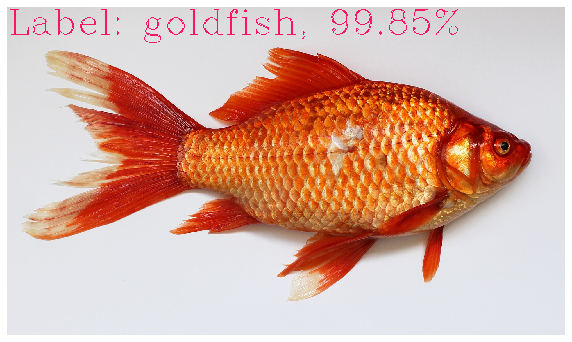

In [63]:
classify(size=4)

**Calling Classifier On other images**

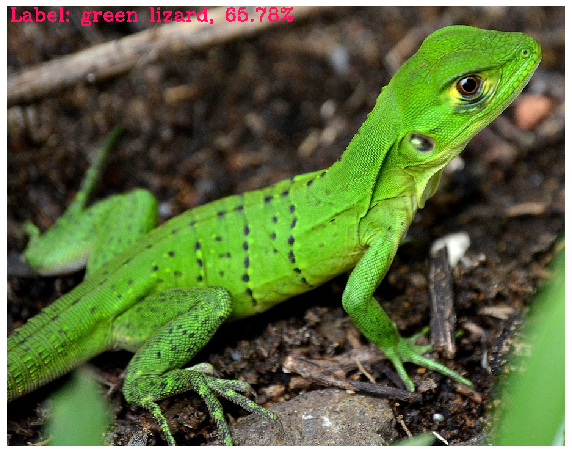

In [64]:
image = cv2.imread('Media/M4/green_lizard.jpg')
classify(image)

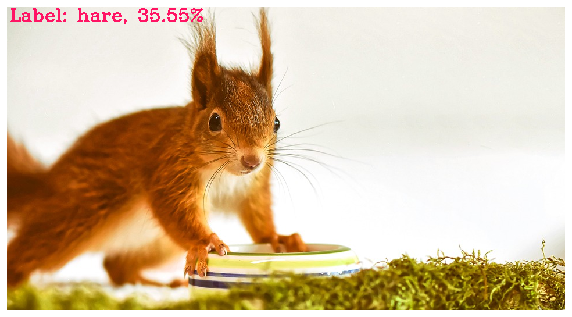

In [65]:
image = cv2.imread('Media/M4/jemma2.jpg')
classify(image)

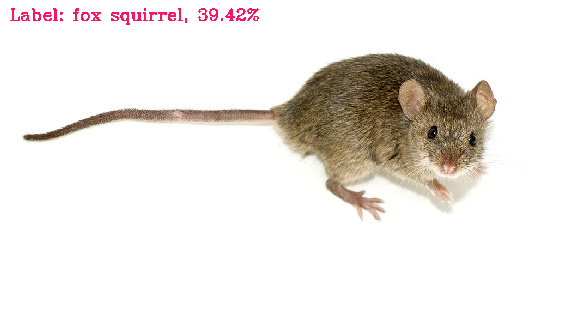

In [66]:
image = cv2.imread('Media/M4/mouse.jpg')
classify(image)

####  Capturing Image from Camera

In [ ]:
classify(usercam = True)

**Instead of Plotting you can get lables and images only**

In [67]:
image, result= classify(n=3, returndata=True)
for res in result:
   print('Label:{} Confidence: {:.2f}%'.format(res[0],res[1]))

Label:goldfish Confidence: 99.85%
Label:banded gecko Confidence: 0.05%
Label:axolotl Confidence: 0.03%


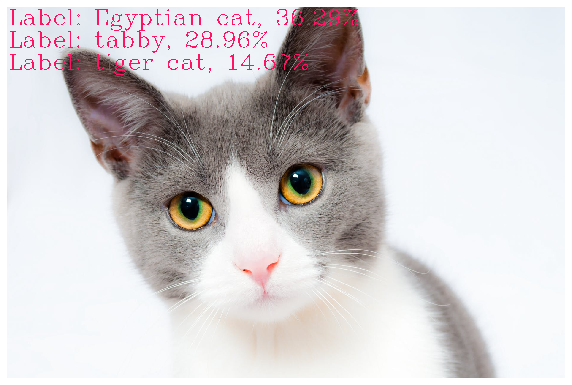

In [68]:
image = cv2.imread('Media/M4/cat.jpeg')
classify(image=image, n=3, size=2.5)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>
Note using GPU Increases the Speed, it may or may not be available on your PC. <br>
Also remember the first iteration is going take a long time but the next iterations will be fast. Also there are some models which perform slower in GPU as compared to CPU.

**Note: Obviously GPU only works if you have them in your system**

**CPU Time**

In [69]:
init_classify()

In [71]:
%%time
image, result= classify(image = image, returndata=True)

Wall time: 63 ms


**Intel GPU**

In [72]:
init_classify(usegpu = 'opencl')

In [74]:
%%time
image, result= classify(image = image, returndata=True)

Wall time: 697 ms


**NVIDIA GPU**

In [ ]:
init_classify(usegpu = 'cuda')

In [ ]:
%%time
image, result= classify(image = image, returndata=True)

## <font style="color:rgb(134,19,348)">Real time Image Classification</font>

In [77]:
fps = 0
init_classify()  

cap=cv2.VideoCapture(1, cv2.CAP_DSHOW) 

while(True):    
    
    start_time = time.time()    
    ret, frame=cap.read() 
    if not ret:
        break
        
    image = cv2.flip(frame,1) 
    
    image, _ = classify(image, n=3, returndata=True)
    
    cv2.putText(image, 'FPS: {:.2f}'.format(fps), (470, 20), cv2.FONT_HERSHEY_COMPLEX,0.8, (255, 20, 55), 2)
    cv2.imshow("Image",image)
    
    fps= (1.0 / (time.time() - start_time))
    k = cv2.waitKey(1)
    if k == 27:
        break
        
cap.release() 
cv2.destroyAllWindows() 